In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 데이터 준비 (Data Preparation)
- 데이터 경로 설정
- 클래스별 이미지 개수 확인
- 데이터셋 분할 (Train, Validation, Test)

In [ ]:
# 필수 라이브러리 불러오기

import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

# 데이터 경로
# - /content/drive/MyDrive/: Google Drive 경로
data_dir = '/content/drive/MyDrive/crack/crack_1000'

# 데이터 디렉토리 내 파일 및 폴더 목록 출력
for path in os.listdir(data_dir):
    print(path)

# 'positive'과 'negative' 디렉토리 내 파일 개수 출력
leng1 = len(os.listdir(data_dir + "/positive"))
leng2 = len(os.listdir(data_dir + "/negative"))
print(f"leng1={leng1}, leng2={leng2}")

# 특정 폴더 내 JPG 파일 경로 리스트를 가져와서 정렬
# - 이 코드는 긍정적(positive) 이미지와 부정적(negative) 이미지의 목록을 가져옴
dir1 = glob.glob(data_dir + "/positive/*.jpg")
dir2 = glob.glob(data_dir + "/positive/*.jpg")
dir1.sort()
dir2.sort()
print(f"leng1={len(dir1)}, leng2={len(dir2)}")

#print(dir1)
#print(dir2)

# 학습을 위한 디바이스 설정 (GPU가 사용 가능하면 'cuda', 그렇지 않으면 'cpu' 사용)
# - torch: GPU인지 아닌지 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device={device}")



negative
positive
leng1=1000, leng2=1000
leng1=1000, leng2=1000
device=cuda


## 하이퍼파라미터 설정 (Hyperparameter Setting)
- 배치 크기 설정
- 학습률 설정
- 에포크 수 설정

In [ ]:
# 하이퍼파라미터 설정
batch_size = 64         # 배치 크기 설정 # 1400개 중에서 32개씩 묶어서 학습한다
num_epochs = 10         # 학습할 에포크 수 설정
learning_rate = 0.001   # 학습률 설정

# 데이터 전처리
# - Resize: 이미지를 224x224 크기로 조정
# - ToTensor: 이미지를 텐서로 변환
# - Normalize: 각 채널의 평균과 표준편차로 정규화
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 데이터셋 로드
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
# 전체 데이터 개수
total_count = len(full_dataset)
print(f"Total number of images: {total_count}")
# 라벨,클래스 확인하기
print(full_dataset.class_to_idx)



Total number of images: 2000
{'negative': 0, 'positive': 1}


## 데이터 전처리 (Data Preprocessing)
- 이미지 크기 조정 (224x224)
- 텐서 변환
- 정규화 (Normalize)

In [ ]:
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
print(f"train_size={len(train_dataset)}")
print(f"val_size={len(val_dataset)}")
print(f"test_size={len(test_dataset)}")


# 배치 크기 및 전체 배치 수 확인
print(f"Batch size: {train_loader.batch_size}")
print(f"Total number of batches per epoch: {len(train_loader)}")


train_size=1400
val_size=300
test_size=300
Batch size: 64
Total number of batches per epoch: 22


## 모델 및 손실 함수, 옵티마이저 설정 (Model, Loss Function & Optimizer Setup)
- MobileNetV2 모델 불러오기 (pretrained=True를 통해 사전 학습된 가중치 사용)
- 출력 레이어 수정 (이진 분류에 맞게)


- 손실 함수: CrossEntropyLoss
- 옵티마이저: Adam (learning rate 설정)

In [ ]:
# 1. MobileNetV2 모델 불러오기 (pretrained=True를 통해 사전 학습된 가중치 사용)
model = models.mobilenet_v2(pretrained=True)
# 출력 레이어 수정 (이진 분류)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
model = model.to(device)

# 손실 함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 94.9MB/s]


## 학습 및 검증 함수 정의 (Define Train and Validation Functions)
- train 함수: 학습 데이터로 모델의 가중치를 업데이트
- validate 함수: 검증 데이터를 통해 모델의 성능 평가

In [ ]:
# 학습 및 검증 함수 정의
def train(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    num_batches = len(loader)
    print(f"num_batches={num_batches}")

    for i, (images, labels) in enumerate(loader):
        print(f"[{i+1}/{num_batches}]", end=" ")
        images, labels = images.to(device), labels.to(device)
        # print(f"images.shape={images.shape}")
        # print(f"labels.shape={labels.shape}")
        # print(f"labels={labels}")
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return running_loss / total, correct / total

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return running_loss / total, correct / total


## 학습 수행 (Training Process)
- 각 에포크마다 train과 validate 함수를 호출하여 학습 및 검증 수행
- 손실과 정확도를 기록

In [ ]:
# 학습 및 검증 기록을 위한 리스트
train_losses = []
val_losses = []
val_accuracies = []

# 학습 과정
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")





num_batches=22
[1/22] [2/22] [3/22] [4/22] [5/22] [6/22] [7/22] [8/22] [9/22] [10/22] [11/22] [12/22] [13/22] [14/22] [15/22] [16/22] [17/22] [18/22] [19/22] [20/22] [21/22] [22/22] Epoch [1/10], Train Loss: 0.0583, Validation Loss: 0.0768, Validation Accuracy: 0.9933
num_batches=22
[1/22] [2/22] [3/22] [4/22] [5/22] [6/22] [7/22] [8/22] [9/22] [10/22] [11/22] [12/22] [13/22] [14/22] [15/22] [16/22] [17/22] [18/22] [19/22] [20/22] [21/22] [22/22] Epoch [2/10], Train Loss: 0.0021, Validation Loss: 0.0710, Validation Accuracy: 0.9933
num_batches=22
[1/22] [2/22] [3/22] [4/22] [5/22] [6/22] [7/22] [8/22] [9/22] [10/22] [11/22] [12/22] [13/22] [14/22] [15/22] [16/22] [17/22] [18/22] [19/22] [20/22] [21/22] [22/22] Epoch [3/10], Train Loss: 0.0172, Validation Loss: 0.0002, Validation Accuracy: 1.0000
num_batches=22
[1/22] [2/22] [3/22] [4/22] [5/22] [6/22] [7/22] [8/22] [9/22] [10/22] [11/22] [12/22] [13/22] [14/22] [15/22] [16/22] [17/22] [18/22] [19/22] [20/22] [21/22] [22/22] Epoch [4/10

## 학습 결과 시각화 (Visualization of Training Results)
- 학습 손실 및 검증 손실을 그래프로 시각화
- 검증 정확도 변화 시각화

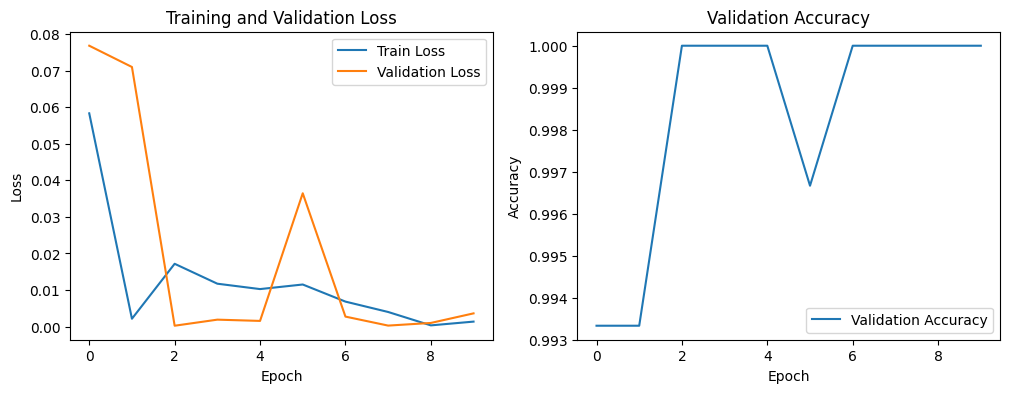

In [ ]:
# 학습 결과 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')
plt.show()

## 태스트 데이터로 평가 (Evaluation on Test Data)
- 테스트 데이터를 이용하여 모델의 최종 성능 평가
- 테스트 손실 및 정확도 출력

In [ ]:
# 테스트 데이터로 평가
test_loss, test_acc = validate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.0051, Test Accuracy: 1.0000


## 모델 가중치 저장 (Save Model Weights)
- 학습이 완료된 모델의 가중치를 파일로 저장하여 나중에 재사용할 수 있도록 함

In [ ]:
save_path = '/content/drive/MyDrive/crack/mobilenet_v2_weights.pth'

# 모델의 가중치를 저장
torch.save(model.state_dict(), save_path)